## Geodata Mask Module Sample Scripts

#### Jeffrey Feng (j1feng@ucsd.edu), July 2021

# Introduction

Geodata is also able to process raster files and geospatial shapefiles. Built off the Rasterio library, its mask module function includes adding shapefiles into binary mask layers, merging and flattening multiple raster images together, and extracting region data from merged mask and shapefiles.

Its current functionalities are:

- Creating mask, adding layers from .tif files

- CRS conversion, cropping, trimming, binarizing layers

- Merging and flattening layers

- Adding shape files as layers

- Extracting shapes from mask layers

In [ ]:
import geodata
import numpy as np
import logging
logging.basicConfig(level=logging.INFO)
from geodata.mask import show

`import geodata` is required to use **geodata**, while launching a logger allows for detailed debugging via the console.

On the other hand, `import numpy as np` and `from geodata.mask import show` are not required. They are only the dependency for this demo. You may also call the show method by calling its full name "geodata.mask.show()".

We would use the four following tif files to run this demo:
    
- Elevation_Slope.tif
- FINAL_GRID_5BINS.tif
- FINAL_GRID_FOREST_MED.tif
- MODIS_China.tif

These tif files can be downloaded in https://drive.google.com/drive/u/1/folders/1uRnVkzZdY2SU3pzU8TiygBUVBMhxrvaJ

In [ ]:
#These can be relative path if you downloaded these files in the same folder as this notebook
slope_path = 'elevation_slope.tif' #CHANGE IT
grid_bins_path = 'FINAL_GRID_5BINS.tif' #CHANGE IT
forest_med_path = 'FINAL_GRID_FOREST_MED.tif' #CHANGE IT
modis_china_path = 'MODIS_China.tif' #CHANGE IT

## CREATING OBJECT, ADDING LAYERS

The four methods below perform same functions. A user may add a layer to the Mask by specifying paths when a new instance is created, or use the `add_layer` method.

We wil add the following two files: `FINAL_GRID_5BINS.tif`, and `FINAL_GRID_FOREST_MED.tif` to the `China` Mask, and name them `bins` and `forest` layers.

In [ ]:
china = geodata.Mask("China", layer_path = grid_bins_path)
china.rename_layer('FINAL_GRID_5BINS', 'bins')
china.add_layer(forest_med_path, layer_name = 'forest')

In [ ]:
china = geodata.Mask("China")
china.add_layer(layer_path = {'bins': grid_bins_path, 
                             'forest': forest_med_path})

In [ ]:
china = geodata.Mask("China", layer_path = [grid_bins_path, forest_med_path], 
             layer_name = ['bins', 'forest'])

In [ ]:
china = geodata.Mask("China", layer_path = {'bins': grid_bins_path, 
                              'forest': forest_med_path})

In [ ]:
china

About the `china` mask we created:

Each Mask object had an attribute `layers`, which is a dictionary of name (key)  - rasterio file opener (values). The <\open DatasetReader> can be the input for many other mask methods for the module.  


[FYI: not important for its normal usage, but it may be helpful]: Although we save openning layerd in Rasterio, which only reads/opens/writes data on disk, sometimes we may have in-memory tif files in the `layers` attributes, and the product `merged_mask` and `shape_mask` are also in-memory temporary files. This is because we might create a new layer after automatic CRS conversion if we detect that the input file is not in latitude-longitude CRS, and in rasterio, a CRS conversion, merging-flattening, shapes on raster, cropping, and many other methods that make changes to the raster will requires creating a new file on disk, but we can avoid creating too many temporarily files and deleting them later by using memory files. Read more here: https://rasterio.readthedocs.io/en/latest/topics/memory-files.html

The other attributes are:

`merged_mask`: the merged and flatten mask of its layers, the merged raster from `layers`

`shape_mask`: similar to the `layers` attribute, but a dictionary of extracted shapes from the merged mask by default. Users may also extracted shape masks from specified layers in `self.layers`.

`saved`: whether this mask object has been saved locally.

`mask_dir`: the directory to save the mask object, by default it should be the path in config.py.



To finish adding all the layers: add another layers `Elevation_Slope.tif` as `slope`.

In [ ]:
china.add_layer(slope_path, layer_name = 'slope')

Some useful methods for the layers:

Get resolution

In [ ]:
china.get_res()

If we want to compare the area of the grid cell, so we know which layer has the smallest unit in term of product of coordinate difference of latitude/longitude. 

Note: it is not area of grid cells.

In [ ]:
china.get_res(product = True)

Get bounds

In [ ]:
china.get_bounds()

### CRS conversion, trimming, cropping (if necessary)

Method `open_tif` can open a raster file without adding it to the layer of a mask, this allows us to visualize it before-hand.

In [ ]:
geodata.mask.open_tif(modis_china_path, show=True)

The `add_layer` method incorporate CRS conversion, let us see what the layer look like after we add it to the object.

This method will overwrite the layer by default, if it is in the object already.

In [ ]:
china.add_layer(modis_china_path, layer_name = 'modis')

The `show` method will try to show the proper latitude and longitude by default, once the layer is in correct CRS. However, a problem with the result below is that there are too many surrounding columns, or maybe rows, that are all zero, and we might want to trim it as a result. We can add the layer again.

We can use `remove_layer` method to remove a layer to mask `china`, method `add_layer` by default can simply replace the old layer as well.

In [ ]:
#geodata.mask.show(china.layers['modis'])
show(china.layers['modis'])

In [ ]:
#china.remove_layer('modis')
china.add_layer('MODIS_China.tif', layer_name = 'modis', trim = True)

In [ ]:
show(china.layers['modis'])

We can also **arbitrary** crop a raster/layer: method `crop_layer` can take either starting indices of top/left, ending indices of right/bottom, or coordinates values in lat/long to trim the raster.

We also have a method `crop_raster` (`geodata.mask.crop_raster`) similarly to `crop_layer` but we can have any raster as input, which indicates that users do not need to add a raster as a layer to call that method. (Similar method: `trim_layer`/`trim_raster`, `binarize_layer`/`binarize_raster`).

In [ ]:
china.crop_layer('modis', bounds = (73, 17, 135, 54))
#same thing with: china.layers['modis'] = geodata.mask.crop_raster(china.layers['modis'], (73, 17, 135, 54)) #similar to 5bins
show(china.layers['modis'])

### Categorical Value Extraction, if necessary

However, the modis layer have 17 distinct values, we may want to create a layer of binary values, indicating unavailable land as 0, and available land as 1. 

Values 1, 2, 3, 4, 5 are 5 types of forest for the modis layer, let us use method `binarize_raster` to create a layer of `modis_forest` mask with 1 and 0. 1, 2, 3, 4, 5 will be unavailable land, therefore we need to take in the rest of the values to make them 1 (available).



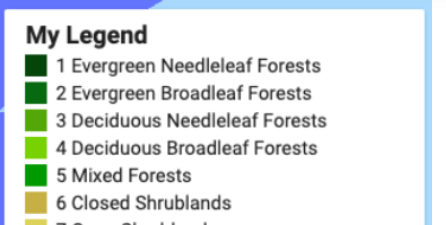

In [ ]:
values = np.arange(6, 18)
values

In [ ]:
china.layers['modis_forest'] = geodata.mask.binarize_raster(china.layers['modis'], values = values)
china.remove_layer('modis')

## MERGING FLATTENING LAYERS

Check all the existing layers:

In [ ]:
geodata.mask.show_all(china.layers)

#### (binary) AND method

By default, the `merge_layer` method will use a binary 'and' method: if any of the n grid cells of the n layers at the same location have 0, then the returned `self.merged_layer` will also have 0 at that location. In other words, if all the layers indicate that a land is not unavailable (!=0), the merged result will have value 1.

`merge_layer` may also take in an optional parameter `layers`, which is a list of layer names stored in the object. If users do not wish to create the final merged mask with all layers, they can specify which layers to use.

In [ ]:
china.merge_layer(attribute_save = False, layers = ['bins', 'forest'])

#### sum method

The sum method will add up the values from all the layers. We can also customize the weights. The behind scene of this method is that it multiplys each layers with the corresponding weight, and add the in-memory temporary layers together.

In [ ]:
china.merge_layer(method = 'sum')

This distribution is completely arbitrary for the purpose of demonstration of the module:
- bins: 5%, forest: 25%, slope 40%, and modis_forest 30%. 

In [ ]:
china.merge_layer(method = 'sum', weights = {
    'bins': 0.05,
    'forest': 0.25,
    'slope': 0.4,
    'modis_forest': 0.3
})

The result mask use the grid cell resolution with the layer with the **finest resolution**. We can also trim the border of the merged mask since not 4 layers have the same boundary, and the border values are not useful. We can set the parameter `trim` to be `True`.

In [ ]:
china.merge_layer(method = 'sum', weights = {
    'bins': 0.05, 'forest': 0.25, 'slope': 0.4, 'modis_forest': 0.3
}, trim = True)

## LOADING SHAPES, EXTRACTING SHAPE FROM MASK

Get provinces shapes from https://scitools.org.uk/cartopy/docs/v0.15/tutorials/using_the_shapereader.html to save the path as a string `prov_path`, this can also be the path to any shape files users have.

In [ ]:
import cartopy.io.shapereader as shpreader

In [ ]:
prov_path = shpreader.natural_earth(resolution='10m', category='cultural', name = 'admin_1_states_provinces')
prov_path

Check attributes in the shapes contained in path `prov_path`

In [ ]:
#geodata.mask.shape_attribute(prov_path)

In jupyter notebook, check out the get_shape() method for its docstring.

In [ ]:
geodata.mask.get_shape?

In [ ]:
china_all_shapes = geodata.mask.get_shape(prov_path, key = 'name_en', 
                         condition_key = 'admin', condition_value = 'China')
china_all_shapes

We can also ignore condition, just take three provinces of China by listing them.

In [ ]:
china_shapes = geodata.mask.get_shape(prov_path, key = 'name_en', 
                         targets = ['Jiangsu', 'Zhejiang', 'Shanghai'],
                         return_dict = True)
china_shapes

Extract the shapes from the merged_mask:

In [ ]:
china.extract_shapes(china_shapes, crop = True)

In [ ]:
geodata.mask.show_all(china.shape_mask)

In [ ]:
china

## SHAPE AS LAYER

This is different from shape extractions, as we will simply treat one shp file as a layer, instead of extracting the merged mask value within that shape.

The `add_shape_layer` method take in a dictionary of shapes, a resolution of the result raster with that shape.

In [ ]:
china.add_shape_layer({'Jiangsu': china_shapes['Jiangsu']}, 
                      resolution = (5000, 5000))
show(china.layers['Jiangsu'])

The previous method call is great when we do not have any layers in the mask object at all. However, since we already have bins, forest, and slope... as the layers, we may want to make the shape layers the similar resolution, and similar boundary with the other layers. We can just specify a `reference_layer` in the method call. We can set it to a layer name in the mask, and the result layer resolution and bounds of the shape layer will be same with that specified layer in the mask object.

In [ ]:
china.add_shape_layer(china_shapes, 
                      reference_layer = 'bins')
show(china.layers['Jiangsu'])

## SAVING MASK

In [ ]:
china.save_mask()

Note that since "Mask has been saved", we can now load the layers or shapes with xarray.

In [ ]:
shape_xr_lst = china.load_shape_xr()
shape_xr_lst['Zhejiang']

In [ ]:
shape_xr_lst['Zhejiang'].plot()

Optional: closing all the files when saving the mask. This can avoid possible write permission error.

In [ ]:
china.save_mask(close_files = True)

### Load a previously saved Mask



In [ ]:
china_2 = geodata.mask.load_mask("china")

In [ ]:
show(china_2.merged_mask)

### Possible errors to avoid

If you create another object `china_2` that opens the raster object `china` is accessing, and then try to save the original `china` without using `china_2.close_files()`, you should expect an error because Python does not want you to rewrite a file that is used by another program. Therefore, `china_2.close_files()` or `china_2.save_mask(close_files = True)` make sures that only one mask is having access to the files. `close_files()` will close all the layers in china_2 and make that mask object un-savable. Therefore, it is best to avoid having multiple mask objects accessing the same files.

Please see the jupyter notebook for more details.